In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd
import pickle
import os

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import StratifiedKFold

from sklearn.base import BaseEstimator, TransformerMixin, clone

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn import set_config

import random
from deap import base, creator, tools, algorithms

import multiprocessing

from cuml.svm import LinearSVC as cuSVC
from cuml import LogisticRegression as cuLR
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.ensemble import RandomForestClassifier as cuRF
from cuml.naive_bayes import GaussianNB as cuNB
from sklearn.naive_bayes import GaussianNB as skNB
from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.neighbors import KNeighborsClassifier as skKNN
from sklearn.svm import LinearSVC as skSVC
from sklearn.linear_model import LogisticRegression as skLR

import shap

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
class FeatureSetChromosome(object):
    def __init__(self, genes, size):
        self.genes = np.random.choice(genes, size)
    
    def get_genes(self):
        return self.genes
    
    def __len__(self):
        return len(self.genes)
    
    def __iter__(self):
        yield from self.genes
    
    def __getitem__(self, key):
        return self.genes[key]
    
    def __setitem__(self, key, data):
        self.genes[key] = data

# setting individual creator
creator.create('FitnessMulti', base.Fitness, weights=(1, -1))
creator.create('Individual', FeatureSetChromosome, fitness=creator.FitnessMulti)

def mutate(individual, pb=0):
    # maximal amount of mutated genes
    n_mutated_max = max(1, int(len(individual) * pb))
    # generate the random amount of mutated genes
    n_mutated = random.randint(1, n_mutated_max)
    # select random genes which need to be mutated
    mutated_indexes = random.sample(list(range(len(individual))), n_mutated)
    # mutation
    for index in mutated_indexes:
        individual[index] = 0 if individual[index] else 1 # flip between 0s and 1s
    return individual,

def evaluate(individual, model, X, y, n_splits=3):
    features = [name for name, selected in zip(list(X.columns), individual.get_genes()) if selected == 1]
    clf = clone(model)
    folds = cross_val_score(
        clf, 
        X[features], 
        y, 
        cv=n_splits,
        scoring='roc_auc_ovr_weighted')
    return folds.mean(), sum(individual.get_genes())

class GATransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model):   
        self.model = model
    
    def fit(self, X, y=None):
        self.feature_names_in_ = list(X.columns)
        
        def init_individual(ind_class, genes=None, size=None):
            return ind_class(genes, size)
        
        toolbox = base.Toolbox()
        
        n_features = len(X.columns)
        toolbox.register(
            'individual', init_individual, creator.Individual,
            genes=[0, 1], size=n_features)
        toolbox.register(
            'population', tools.initRepeat, list, toolbox.individual)

        # raise population
        self.pop = toolbox.population(10)

        toolbox.register('mate', tools.cxTwoPoint)
        toolbox.register('mutate', mutate, pb=0.2)
        toolbox.register('evaluate', evaluate, model=self.model, X=X, y=y, n_splits=3)
        toolbox.register('select', tools.selNSGA2)
        
        pool = multiprocessing.Pool()
        toolbox.register("map", pool.map)
        
        auc_stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
        n_feat_stats = tools.Statistics(key=lambda ind: ind.fitness.values[1])
        mstats = tools.MultiStatistics(auc=auc_stats, n_features=n_feat_stats)
        mstats.register("mean", np.mean)
        mstats.register("max", max)
        mstats.register("min", min)

        hof = tools.HallOfFame(3)
        result, logbook = algorithms.eaMuPlusLambda(
            self.pop, toolbox,
            mu=10, lambda_=30, cxpb=0.5, mutpb=0.5,
            ngen=40, stats=mstats, halloffame=hof, verbose=True)
        
        split = 0
        while os.path.exists(f"logbooks/{type(self.model).__name__}-split{split}"):
            split += 1

        with open(f"logbooks/{type(self.model).__name__}-split{split}", "wb") as outfile:
            pickle.dump(logbook, outfile, protocol=pickle.HIGHEST_PROTOCOL)

        fig, ax1 = plt.subplots()

        ax1.set_xlabel('Number of generations')
        ax1.set_ylabel('AUC')
        ax1.plot(logbook.chapters['auc'].select("gen"), logbook.chapters['auc'].select("max"), label="Max AUC")

        ax2 = ax1.twinx()
        ax2.set_ylabel('Number of features')
        ax2.plot(logbook.chapters['n_features'].select("gen"), logbook.chapters['n_features'].select("min"), label="Min features")

        fig.suptitle(f'GA Transformer Evolution: {self.model}')
        fig.legend()
        fig.tight_layout()
        
        plt.show()
        
        self.best_features = hof[0].get_genes()
        return self
    
    def get_feature_names_out(self, input_features=None):
        if input_features is not None:
            return [name for name, selected in zip(input_features, self.best_features) if selected == 1]
        else:
            return [name for name, selected in zip(self.feature_names_in_, self.best_features) if selected == 1]
        
    def transform(self, X, y=None):
        features = [name for name, selected in zip(list(X.columns), self.best_features) if selected == 1]
        return X[features]
    
    def get_params(self, deep=True):
        return {"model": self.model}
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [3]:
df = pd.read_csv("data/CCD-INIDv1/multiclass_data.csv")
X_data = df.drop(['id', 'atk_type'], axis=1)
y_data = df['atk_type']

In [4]:
splits = list(StratifiedKFold(n_splits=5).split(X_data, y_data))

In [5]:
set_config(transform_output="pandas")
np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Fitting 10 combinations
Fitting {'classify': GaussianNB(), 'fs': 'passthrough'}


X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Features seen: 
expiration_idsrc_ipsrc_ip_is_privatesrc_portdst_ipdst_ip_is_privatedst_portprotocolip_versionvlan_idbidirectional_first_seen_msbidirectional_last_seen_msbidirectional_duration_msbidirectional_packetsbidirectional_bytessrc2dst_first_seen_mssrc2dst_last_seen_mssrc2dst_duration_mssrc2dst_packetssrc2dst_bytesdst2src_first_seen_msdst2src_last_seen_msdst2src_duration_msdst2src_packetsdst2src_bytesbidirectional_min_psbidirectional_mean_psbidirectional_stddev_psbidirectional_max_pssrc2dst_min_pssrc2dst_mean_pssrc2dst_stddev_pssrc2dst_max_psdst2src_min_psdst2src_mean_psdst2src_stddev_psdst2src_max_psbidirectional_min_piat_msbidirectional_mean_piat_msbidirectional_stddev_piat_msbidirectional_max_piat_mssrc2dst_min_piat_mssrc2dst_mean_piat_mssrc2dst_stddev_piat_mssrc2dst_max_piat_msdst2src_min_piat_msdst2src_mean_piat_msdst2src_stddev_piat_msdst2src_max_piat_msbidirectional_syn_packetsbidirectional_cwr_packetsbidirectional_ece_packetsbidirectional_urg_packetsbidirectional_ack_pack

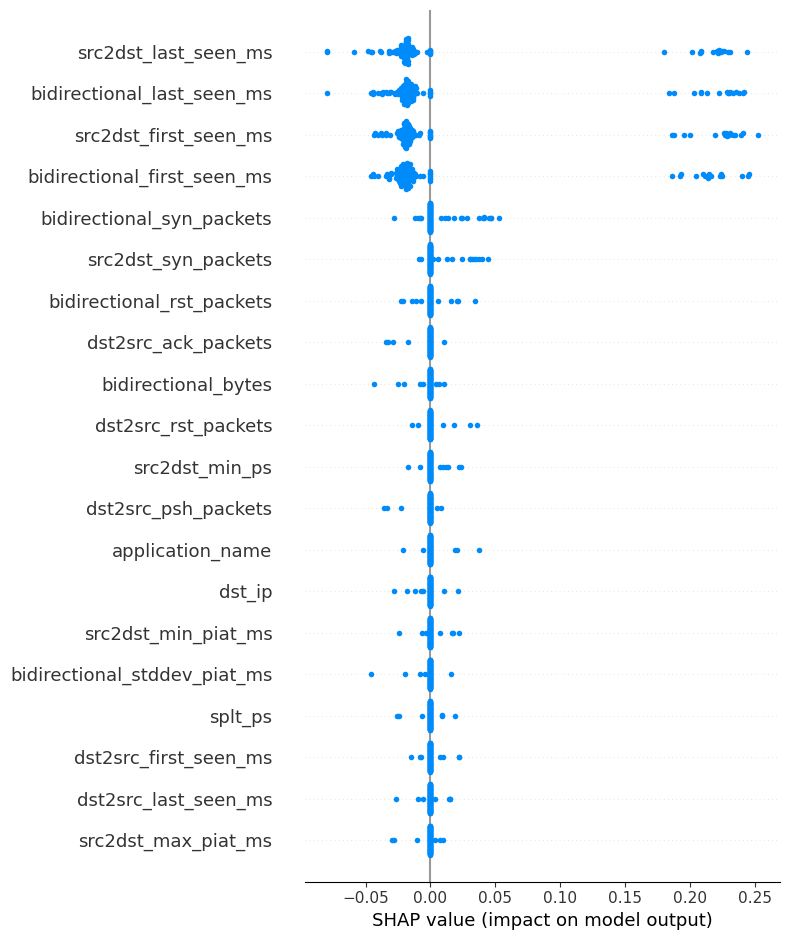

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Features seen: 
expiration_idsrc_ipsrc_ip_is_privatesrc_portdst_ipdst_ip_is_privatedst_portprotocolip_versionvlan_idbidirectional_first_seen_msbidirectional_last_seen_msbidirectional_duration_msbidirectional_packetsbidirectional_bytessrc2dst_first_seen_mssrc2dst_last_seen_mssrc2dst_duration_mssrc2dst_packetssrc2dst_bytesdst2src_first_seen_msdst2src_last_seen_msdst2src_duration_msdst2src_packetsdst2src_bytesbidirectional_min_psbidirectional_mean_psbidirectional_stddev_psbidirectional_max_pssrc2dst_min_pssrc2dst_mean_pssrc2dst_stddev_pssrc2dst_max_psdst2src_min_psdst2src_mean_psdst2src_stddev_psdst2src_max_psbidirectional_min_piat_msbidirectional_mean_piat_msbidirectional_stddev_piat_msbidirectional_max_piat_mssrc2dst_min_piat_mssrc2dst_mean_piat_mssrc2dst_stddev_piat_mssrc2dst_max_piat_msdst2src_min_piat_msdst2src_mean_piat_msdst2src_stddev_piat_msdst2src_max_piat_msbidirectional_syn_packetsbidirectional_cwr_packetsbidirectional_ece_packetsbidirectional_urg_packetsbidirectional_ack_pack

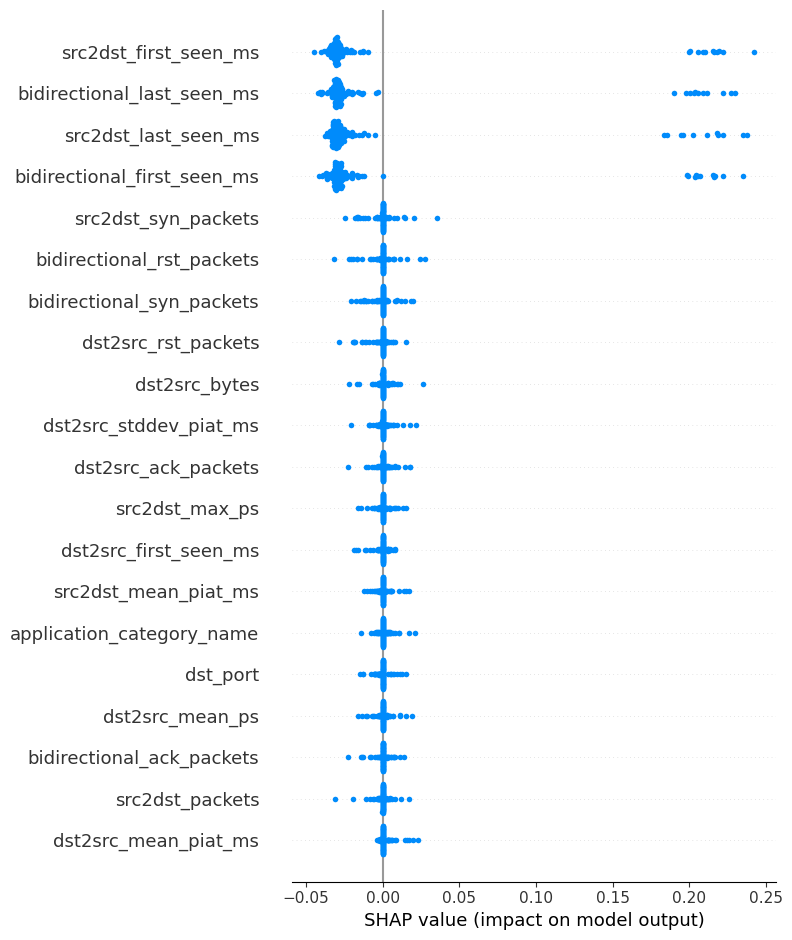

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Features seen: 
expiration_idsrc_ipsrc_ip_is_privatesrc_portdst_ipdst_ip_is_privatedst_portprotocolip_versionvlan_idbidirectional_first_seen_msbidirectional_last_seen_msbidirectional_duration_msbidirectional_packetsbidirectional_bytessrc2dst_first_seen_mssrc2dst_last_seen_mssrc2dst_duration_mssrc2dst_packetssrc2dst_bytesdst2src_first_seen_msdst2src_last_seen_msdst2src_duration_msdst2src_packetsdst2src_bytesbidirectional_min_psbidirectional_mean_psbidirectional_stddev_psbidirectional_max_pssrc2dst_min_pssrc2dst_mean_pssrc2dst_stddev_pssrc2dst_max_psdst2src_min_psdst2src_mean_psdst2src_stddev_psdst2src_max_psbidirectional_min_piat_msbidirectional_mean_piat_msbidirectional_stddev_piat_msbidirectional_max_piat_mssrc2dst_min_piat_mssrc2dst_mean_piat_mssrc2dst_stddev_piat_mssrc2dst_max_piat_msdst2src_min_piat_msdst2src_mean_piat_msdst2src_stddev_piat_msdst2src_max_piat_msbidirectional_syn_packetsbidirectional_cwr_packetsbidirectional_ece_packetsbidirectional_urg_packetsbidirectional_ack_pack

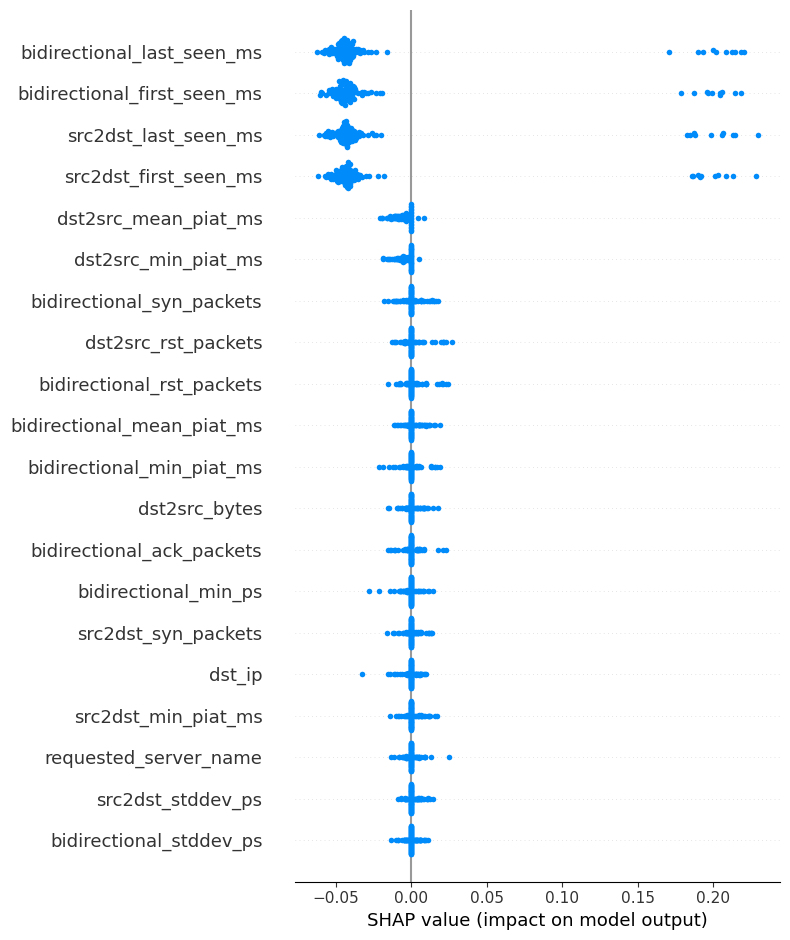

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Features seen: 
expiration_idsrc_ipsrc_ip_is_privatesrc_portdst_ipdst_ip_is_privatedst_portprotocolip_versionvlan_idbidirectional_first_seen_msbidirectional_last_seen_msbidirectional_duration_msbidirectional_packetsbidirectional_bytessrc2dst_first_seen_mssrc2dst_last_seen_mssrc2dst_duration_mssrc2dst_packetssrc2dst_bytesdst2src_first_seen_msdst2src_last_seen_msdst2src_duration_msdst2src_packetsdst2src_bytesbidirectional_min_psbidirectional_mean_psbidirectional_stddev_psbidirectional_max_pssrc2dst_min_pssrc2dst_mean_pssrc2dst_stddev_pssrc2dst_max_psdst2src_min_psdst2src_mean_psdst2src_stddev_psdst2src_max_psbidirectional_min_piat_msbidirectional_mean_piat_msbidirectional_stddev_piat_msbidirectional_max_piat_mssrc2dst_min_piat_mssrc2dst_mean_piat_mssrc2dst_stddev_piat_mssrc2dst_max_piat_msdst2src_min_piat_msdst2src_mean_piat_msdst2src_stddev_piat_msdst2src_max_piat_msbidirectional_syn_packetsbidirectional_cwr_packetsbidirectional_ece_packetsbidirectional_urg_packetsbidirectional_ack_pack

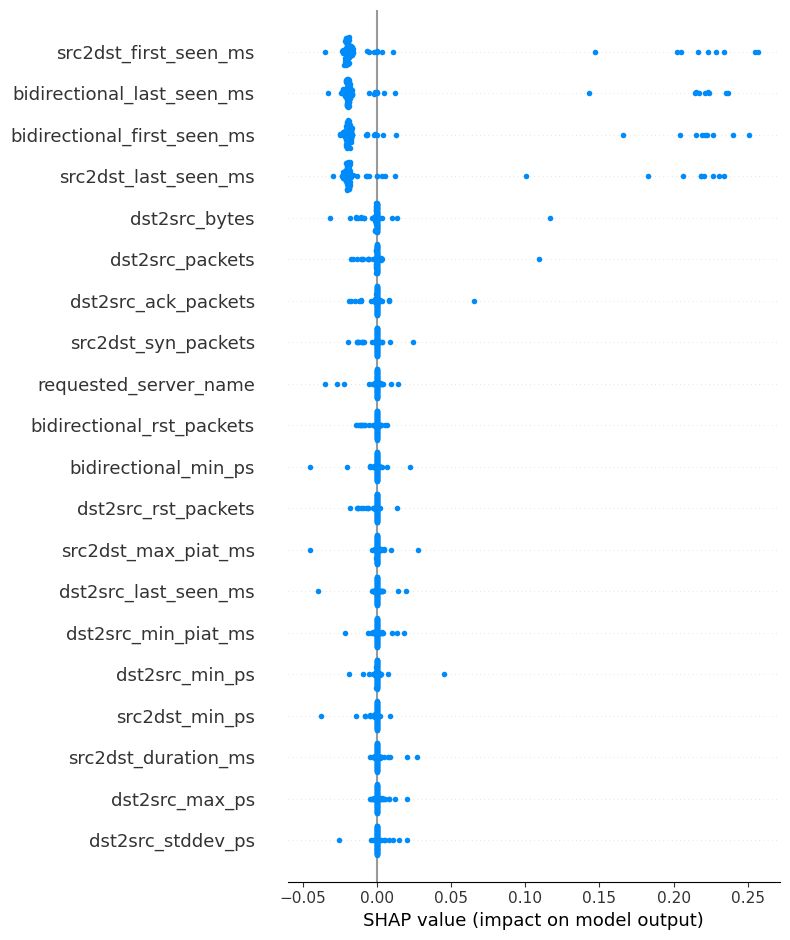

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Features seen: 
expiration_idsrc_ipsrc_ip_is_privatesrc_portdst_ipdst_ip_is_privatedst_portprotocolip_versionvlan_idbidirectional_first_seen_msbidirectional_last_seen_msbidirectional_duration_msbidirectional_packetsbidirectional_bytessrc2dst_first_seen_mssrc2dst_last_seen_mssrc2dst_duration_mssrc2dst_packetssrc2dst_bytesdst2src_first_seen_msdst2src_last_seen_msdst2src_duration_msdst2src_packetsdst2src_bytesbidirectional_min_psbidirectional_mean_psbidirectional_stddev_psbidirectional_max_pssrc2dst_min_pssrc2dst_mean_pssrc2dst_stddev_pssrc2dst_max_psdst2src_min_psdst2src_mean_psdst2src_stddev_psdst2src_max_psbidirectional_min_piat_msbidirectional_mean_piat_msbidirectional_stddev_piat_msbidirectional_max_piat_mssrc2dst_min_piat_mssrc2dst_mean_piat_mssrc2dst_stddev_piat_mssrc2dst_max_piat_msdst2src_min_piat_msdst2src_mean_piat_msdst2src_stddev_piat_msdst2src_max_piat_msbidirectional_syn_packetsbidirectional_cwr_packetsbidirectional_ece_packetsbidirectional_urg_packetsbidirectional_ack_pack

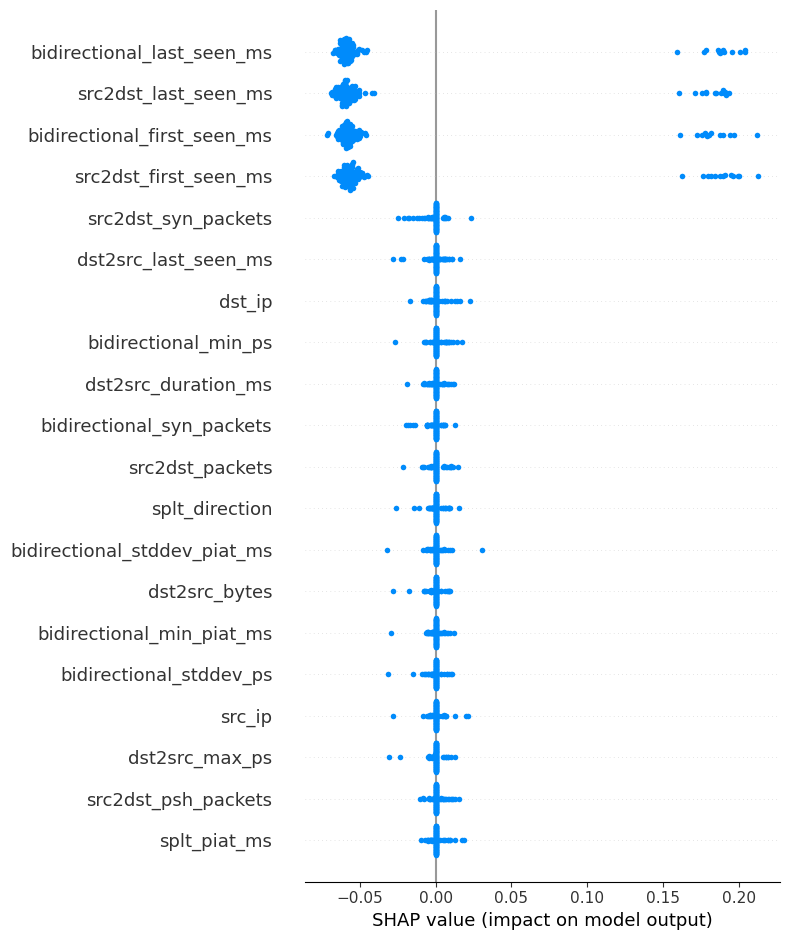

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


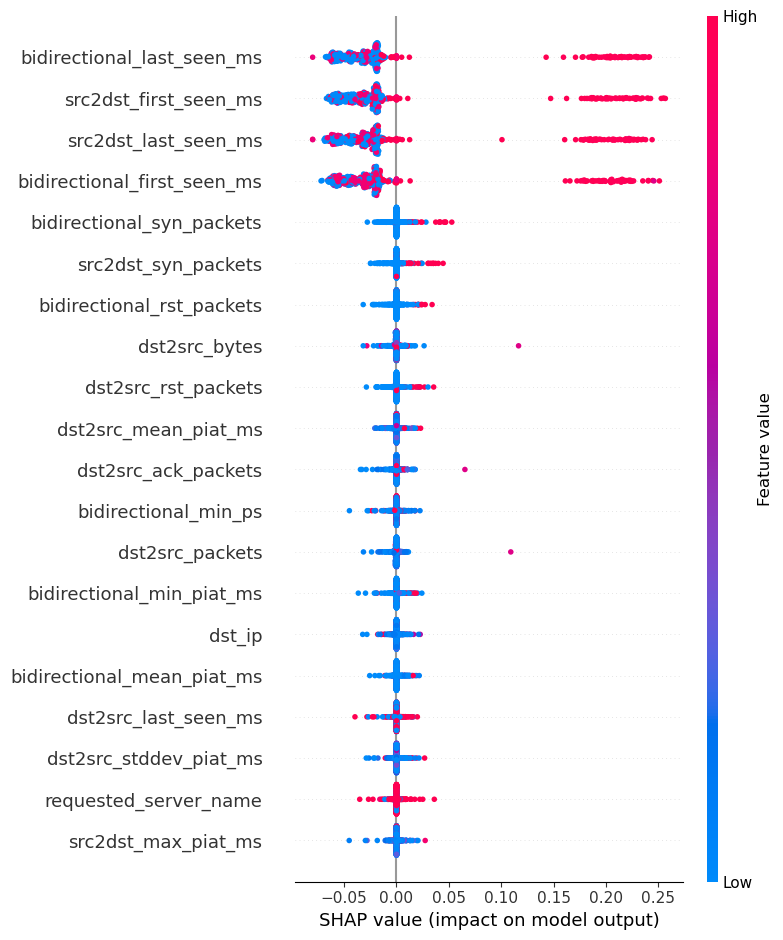

Fitting {'classify': GaussianNB(), 'fs': GATransformer(model=GaussianNB())}
   	      	                         auc                          	              n_features              
   	      	------------------------------------------------------	--------------------------------------
gen	nevals	gen	max     	mean    	min    	nevals	gen	max	mean	min	nevals
0  	10    	0  	0.999864	0.971365	0.71628	10    	0  	50 	41.6	35 	10    
1  	30    	1  	0.999864	0.971234	0.713971	30    	1  	41 	36.9	35 	30    
2  	30    	2  	0.999914	0.915949	0.714237	30    	2  	37 	34.2	31 	30    
3  	30    	3  	0.999914	0.94582 	0.714237	30    	3  	36 	32.1	29 	30    
4  	30    	4  	0.99997 	0.975759	0.758636	30    	4  	37 	30.4	25 	30    
5  	30    	5  	0.999973	0.99991 	0.999783	30    	5  	30 	27.3	24 	30    
6  	30    	6  	0.999975	0.999934	0.999818	30    	6  	30 	26.1	23 	30    
7  	30    	7  	0.99998 	0.999947	0.999873	30    	7  	30 	26.4	23 	30    
8  	30    	8  	0.99998 	0.999946	0.999873	30    	8  	30 	25

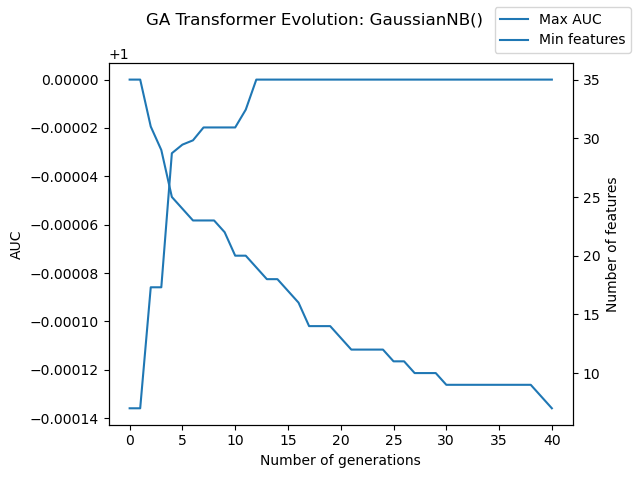

X does not have valid feature names, but StandardScaler was fitted with feature names


  0%|          | 0/100 [00:00<?, ?it/s]

X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScaler was fitted with feature names
X does not have valid feature names, but StandardScale

Features seen: 
bidirectional_first_seen_mssrc2dst_bytesbidirectional_max_psbidirectional_mean_piat_msbidirectional_max_piat_msbidirectional_psh_packetssrc2dst_urg_packets
SHAP values: 
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


IndexError: list index out of range

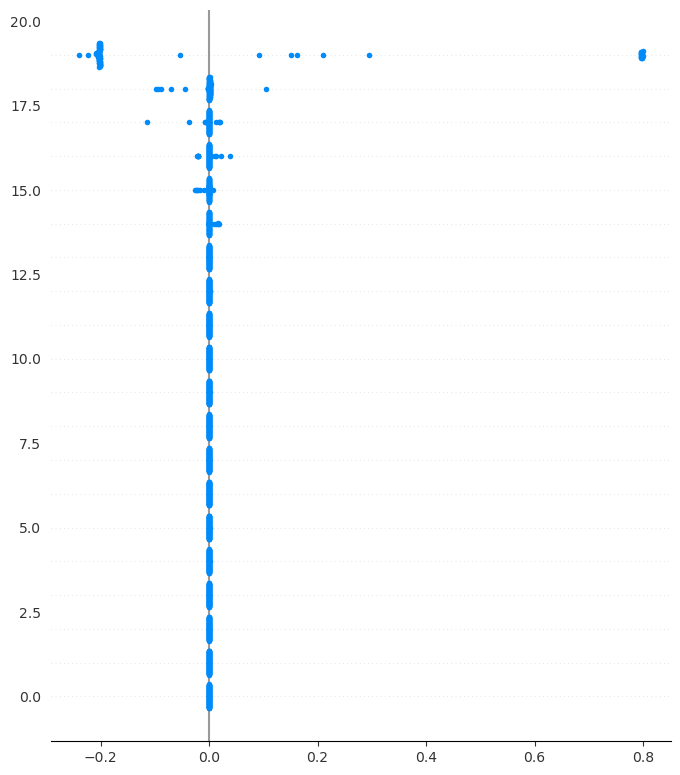

In [6]:
classifier = skNB()
scaler = StandardScaler()
pipe = Pipeline(
    [
        ("scaling", scaler),
        ("fs", "passthrough"),
        ("classify", classifier)
    ],
    memory="cache_other"
)

param_grid = ParameterGrid(
    {
        "fs": ["passthrough",
               GATransformer(model=skNB())],
        "classify": [skNB(),
                           cuRF(n_estimators = 500,
                                                 max_features=1.0),
                           cuLR(),
                           cuSVC(probability=True),
                           cuKNN(n_neighbors=17)]
    }
)

list_shap_values = []
list_test_sets = []
print(f"Fitting {len(param_grid)} combinations")
for params in param_grid:
    print(f"Fitting {params}")

    for train, test in splits:
        cloned_pipe = clone(pipe)
        cloned_pipe.set_params(**params)

        X_train = X_data.iloc[train]
        y_train = y_data.iloc[train]
        X_test = X_data.iloc[test]
        y_test = y_data.iloc[test]

        cloned_pipe.fit(X_train, y_train)

        features_seen = X_train.columns if cloned_pipe.named_steps.fs=="passthrough" else cloned_pipe.named_steps.fs.get_feature_names_out()
        X_train_sample = X_train.sample(n=25)
        explainer = shap.KernelExplainer(cloned_pipe.predict_proba, X_train_sample)

        X_test_sample = X_test.reset_index(drop=True).sample(n=100)
        shap_values = explainer.shap_values(X_test_sample)
        
        print("Features seen: ")
        print(*features_seen, sep="")
        print(f"SHAP values: ")
        print(shap_values[0])
        shap.summary_plot(shap_values = shap_values[1], features=features_seen)

        list_shap_values.append(shap_values)
        list_test_sets.append(test[X_test_sample.index.values])
        
    #combining results from all iterations
    test_set = np.concatenate(list_test_sets,axis=0)
    shap_values = np.concatenate(list_shap_values,axis=1)
    #bringing back variable names    
    X_test = pd.DataFrame(X_data.iloc[test_set],columns=X_data.columns)
    shap.summary_plot(shap_values[1], X_test)